# Código ejemplo procesamiento audio con AG
### Jesus Daniel Caballero Colina
### Inteligencia Artificial y Minirobots


- ___l:___ Número de genes del cromosoma; en AGS, número de bits o longitud del cromosoma
- ___k:___ Gen del cromosoma
- ___K:___ Número de cromosomas en la población
- ___M:___ Número de generaciones del algoritmo
- ___apt:___ Función de aptitud aplicada en el punto 𝒙

Este código utiliza cromosomas no binarios, teniendo en cuenta que cada gen es un sample del audio. Por ello se utilizó:
- GENERACIÓN DE POBLACIÓN: Hay dos posibilidades para algoritmos de generación de población aleatoria:
    - Generación completamente aleatoria (GEN_AUDIO2): Generar un audio completamente random del mismo tamaño que el audio base. Sin embargo este posee la desventaja converger en un numero excesivo de generaciones.
    - Generación parcialmente aleatoria (GEN_AUDIO1): Generar un ruido de una amplitud dependiente al valor original del sample. Este fue el método usado para este ejercicio.
- APTITUD: El algoritmo para calcular la aptitud también sufrió un cambio, ya que se definió en un rango de entre 0 y 10, con 10 para audios identicos al audio base.
- SELECCION: Se uso el algoritmo de ruleta, la cual se pondera por la magnitud de la aptitud de cada individuo.
- CRUCE: Se usó el algoritmo de cruce de tipo Aritmético simple. 
- MUTACIÓN: Se omitió el proceso de mutación en cromosomas hijos ya que como son archivos de sonido, si por algun motivo, algunos samples se cambian aleatoriamente, se refleja en que el audio se escucha con ruido indeseado.

Se creó el audio 'Senores.wav', como audio base para la función de aptitud. 

In [1]:
#SONIDO
import os
from scipy.io import wavfile
from playsound import playsound
#CALCULOS
import numpy as np
import random
from numpy.random import randint,rand
import copy
#GRAFICOS
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from IPython.display import clear_output
#TIEMPOS
import  time

In [2]:
def PROCESAR_AUDIO(name):
    samplerate, data = wavfile.read(name)
    amp = max(max(data[:,0]),max(data[:,1]),max(-data[:,0]),max(-data[:,1]))
    samples = data.shape[0]
    audio = np.zeros(data.shape)
    
    audio[:,0] = [data[i,0]/amp for i in range(samples)]
    audio[:,1] = [data[i,1]/amp for i in range(samples)]
    
    return audio,amp,samplerate

def IMPRIMIR_AUDIO(data,name='img',save=False):
    if data.shape[1] == 1:
        fig = plt.figure(figsize=(20,5))
        ax1 = fig.add_subplot(121)
        ax1.plot(data)
        plt.title(name + ': Canal 1')
    else:
        fig = plt.figure(figsize=(20,5))
        ax1 = fig.add_subplot(121)
        ax1.plot(data[:,0])
        plt.title(name + ': Canal 1')
        ax2 = fig.add_subplot(122)
        ax2.plot(data[:,1])
        plt.title(name + ': Canal 2')
    if save:
        fig.savefig(name+'.png', bbox_inches="tight")

#FUNCIÓN 1 PARA GENERAR AUDIOS (NO SON COMPLETAMENTE ALEATORIOS SINO UNA DISTORSIÓN ALEATORIA PI% DE UN AUDIO BASE)
def GEN_AUDIO1(AUDIO_BASE,Pi):
    samples = AUDIO_BASE.shape[0]
    if len(AUDIO_BASE.shape) == 1:
        MOD = np.zeros([samples,1])
        MOD[:,0] = [frame for frame in np.transpose(np.multiply(AUDIO_BASE,(1+(2*rand(1,AUDIO_BASE.shape[0])-1)*Pi)))]
    else:
        MOD = np.zeros(AUDIO_BASE.shape)
        for i in range(AUDIO_BASE.shape[1]):
            MOD[:,i] = [frame for frame in np.transpose(np.multiply(AUDIO_BASE[:,i],(1+(2*rand(1,AUDIO_BASE.shape[0])-1)*Pi)))]
    return MOD

#FUNCIÓN 2 PARA GENERAR AUDIOS (SON COMPLETAMENTE ALEATORIOS )
def GEN_AUDIO2(AUDIO_BASE):
    samples = AUDIO_BASE.shape[0]
    if len(AUDIO_BASE.shape) == 1:
        MOD = np.zeros([samples,1])
        MOD[:,0] = [frame for frame in 2*rand(AUDIO.shape[0])-1]
    else:
        MOD = np.zeros(AUDIO_BASE.shape)
        for i in range(AUDIO_BASE.shape[1]):
            MOD[:,i] = [frame for frame in 2*rand(AUDIO.shape[0])-1]
    return MOD
    
#FUNCIÓN DE EVALUACIÓN DE APTITUD
def APTITUD(X,AUDIO):
    if type(X) != list:
        apt  = np.zeros([1,1])
        apt[0,0] = 5*(2-np.mean(abs(AUDIO - X)))
    else:
        apt  = np.zeros([len(X),1])
        i = 0
        for x in X:        
            apt[i,0] = 5*(2-np.mean(abs(AUDIO - X)))
            i += 1
    
    return apt

# FUNCIÓN PARA SELECCIÓN DE OPCION CON DIFERENTES PROBABILIDADES
def sel_prob(lst,probability):
    zipped = zip(lst,probability)
    lst = [[i[0]] * int(i[1]*100) for i in zipped]
    new = [b for i in lst for b in i]
    return random.choice(new)

def SELECCION(pob,apt):
    apt_global = sum(apt)
    probability = [apt_crom/apt_global for apt_crom in apt]
    
    pob_sel = []
    for i in range(len(pob)):
        pob_sel.append(sel_prob(pob,probability))
    
    return pob_sel

# FUNCIÓN PARA CRUCE HEURISTICO DE POBLACIÓN
def CRUCE(pob):
    i = 0
    hijos = []
    pob_ext = pob.copy()
    pob_ext.append(pob[0])
    while i < len(pob):
        crom1 = pob_ext[i]
        crom2 = pob_ext[i+1]
        pt = rand(1)
        hijos.append((crom2-crom1)*pt+crom1)
        hijos.append((crom1-crom2)*pt+crom2)
        i = i + 2
    
    return(hijos)

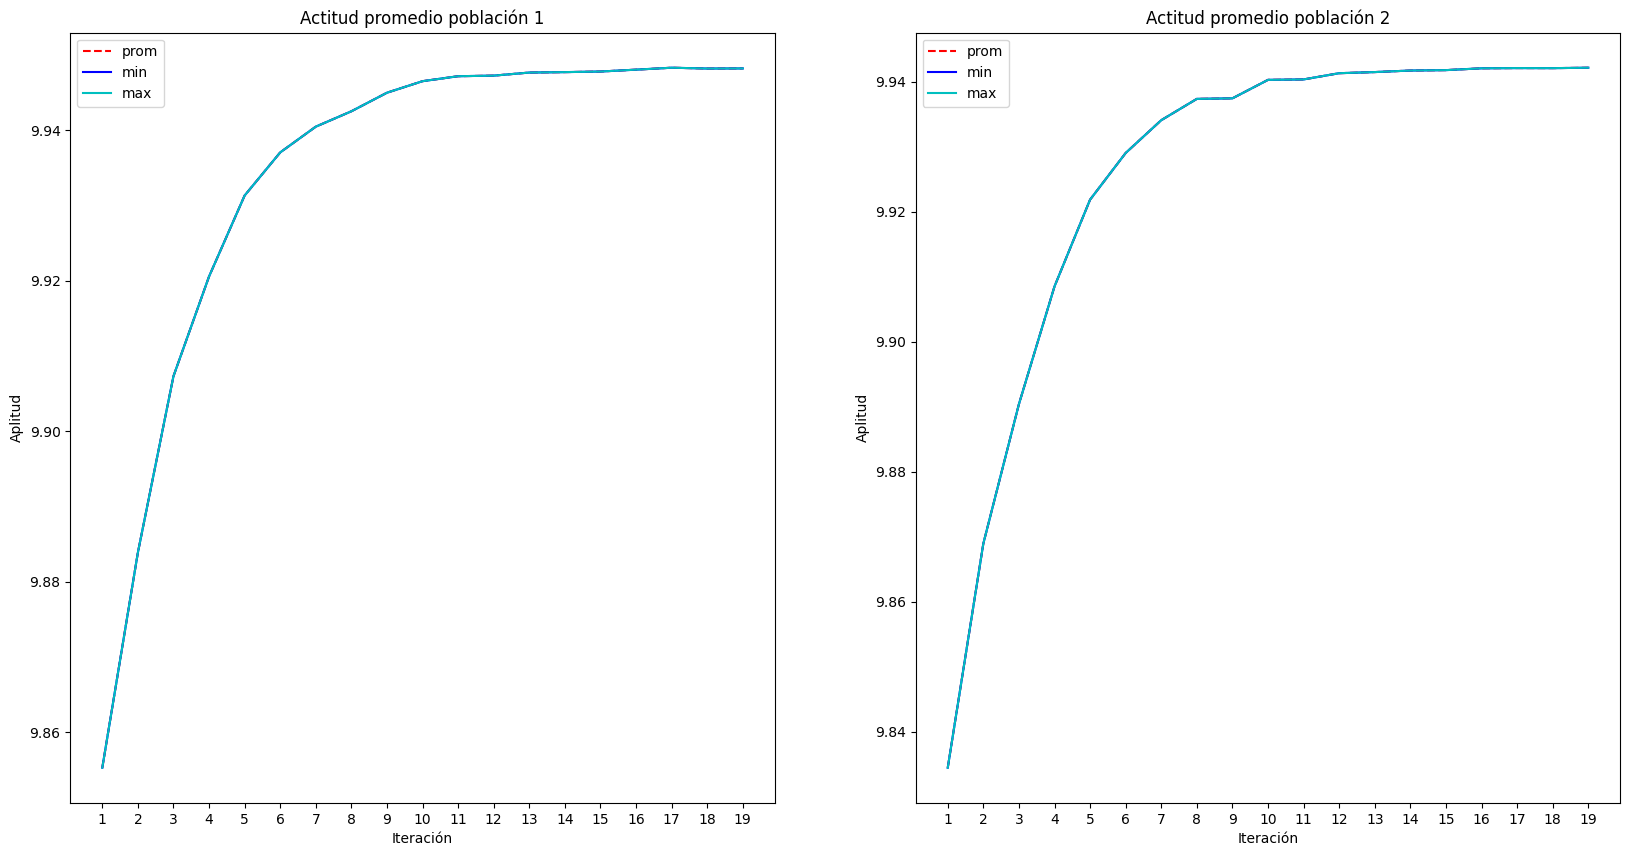

In [3]:
K = 50
M = 20
Pi = 1
k = 20
Audio = 'Senores.wav'
Audio_mod = 'Senores_mod.wav'

AUDIO,amp,rate = PROCESAR_AUDIO(Audio)
canal1 = np.zeros([AUDIO.shape[0],1])
canal2 = np.zeros([AUDIO.shape[0],1])
canal1[:,0] = AUDIO[:,0]
canal2[:,0] = AUDIO[:,1]

#GENERACIÓN POBLACIÓN (ELEGIR ENTRE FUNCIÓN GEN_AUDIO1 O GEN_AUDIO2)
pob1 = [GEN_AUDIO1(canal1,Pi) for _ in range(K)]    #PASO 1
pob2 = [GEN_AUDIO1(canal2,Pi) for _ in range(K)]    #PASO 1
#pob1 = [GEN_AUDIO2(canal1) for _ in range(K)]    #PASO 1
#pob2 = [GEN_AUDIO2(canal2) for _ in range(K)]    #PASO 1
pob1_i = pob1
pob2_i = pob2

apt_gen1 = []
apt_gen2 = []
apt_max_gen1 = []
apt_max_gen2 = []
apt_min_gen1 = []
apt_min_gen2 = []
for generacion in range(M):                        #PASO 2
    #print('____________________________________________________________________________________')
    #print('GENERACIÓN '+str(generacion+1))
    apt1 = APTITUD(pob1,canal1)                    #PASO 2.2
    apt2 = APTITUD(pob2,canal2)                    #PASO 2.2
    pob_sel1 = SELECCION(pob1,apt1)                #PASO 2.3
    pob_sel2 = SELECCION(pob2,apt2)                #PASO 2.3
    hijos1 = CRUCE(pob_sel1)                       #PASO 2.4
    hijos2 = CRUCE(pob_sel2)                       #PASO 2.4
    pob1 = hijos1                                  #PASO 2.6
    pob2 = hijos2                                  #PASO 2.6
    
    if generacion > 0 and generacion%int(M/k) == 0:
        apt_gen1.append(np.mean(apt1))
        apt_gen2.append(np.mean(apt2))
        apt_max_gen1.append(max(apt1))
        apt_max_gen2.append(max(apt2))
        apt_min_gen1.append(min(apt1))
        apt_min_gen2.append(min(apt2))
        
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(121)
        plt.title('Actitud promedio población 1')
        plt.ylabel('Aplitud')
        plt.xlabel('Iteración')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(M/k)))
        ax1.plot(np.arange(int(M/k),generacion+1,int(M/k)),apt_gen1,'r--',label='prom')
        ax1.plot(np.arange(int(M/k),generacion+1,int(M/k)),apt_min_gen1,'b',label='min')
        ax1.plot(np.arange(int(M/k),generacion+1,int(M/k)),apt_max_gen1,'c',label='max')
        ax1.legend()
        ax2 = fig.add_subplot(122)
        plt.title('Actitud promedio población 2')
        plt.ylabel('Aplitud')
        plt.xlabel('Iteración')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(M/k)))
        ax2.plot(np.arange(int(M/k),generacion+1,int(M/k)),apt_gen2,'r--',label='prom')
        ax2.plot(np.arange(int(M/k),generacion+1,int(M/k)),apt_min_gen2,'b',label='min')
        ax2.plot(np.arange(int(M/k),generacion+1,int(M/k)),apt_max_gen2,'c',label='max')
        ax2.legend()
        plt.show()
        clear_output(wait=True)

fig.savefig('Info_AG.png', bbox_inches="tight")

/tmp/ipykernel_15676/2282583220.py:3: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  AUDIO_INICIAL[:,0] = [x*amp for x in pob1_i[0]]
/tmp/ipykernel_15676/2282583220.py:4: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  AUDIO_INICIAL[:,1] = [x*amp for x in pob2_i[0]]
/tmp/ipykernel_15676/2282583220.py:7: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In th

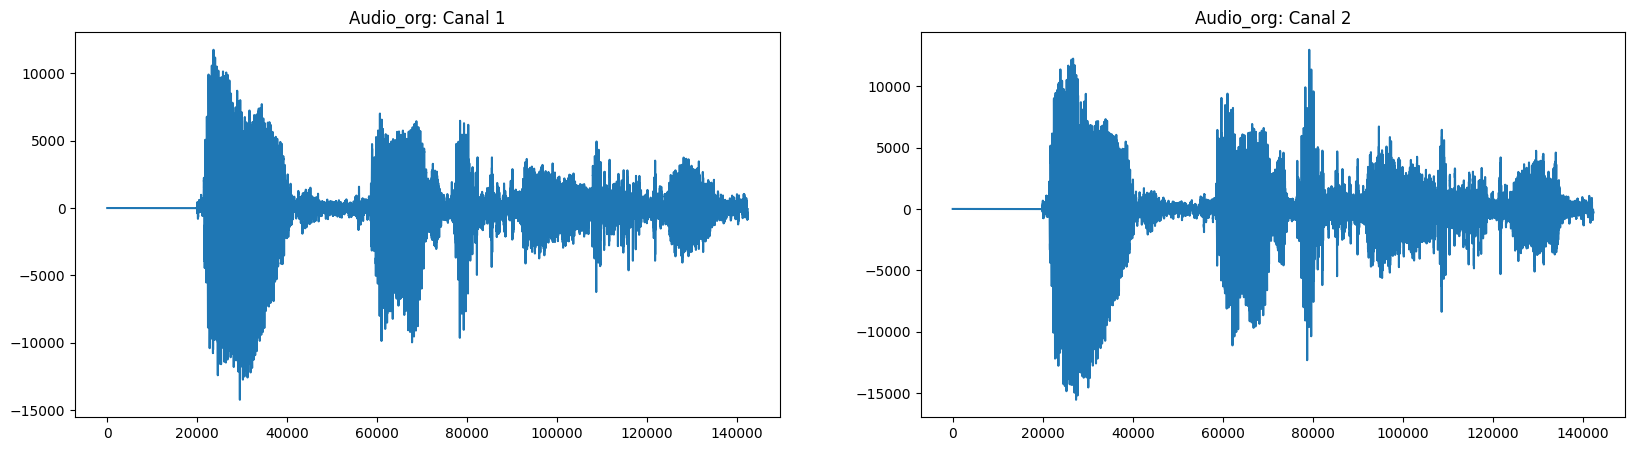

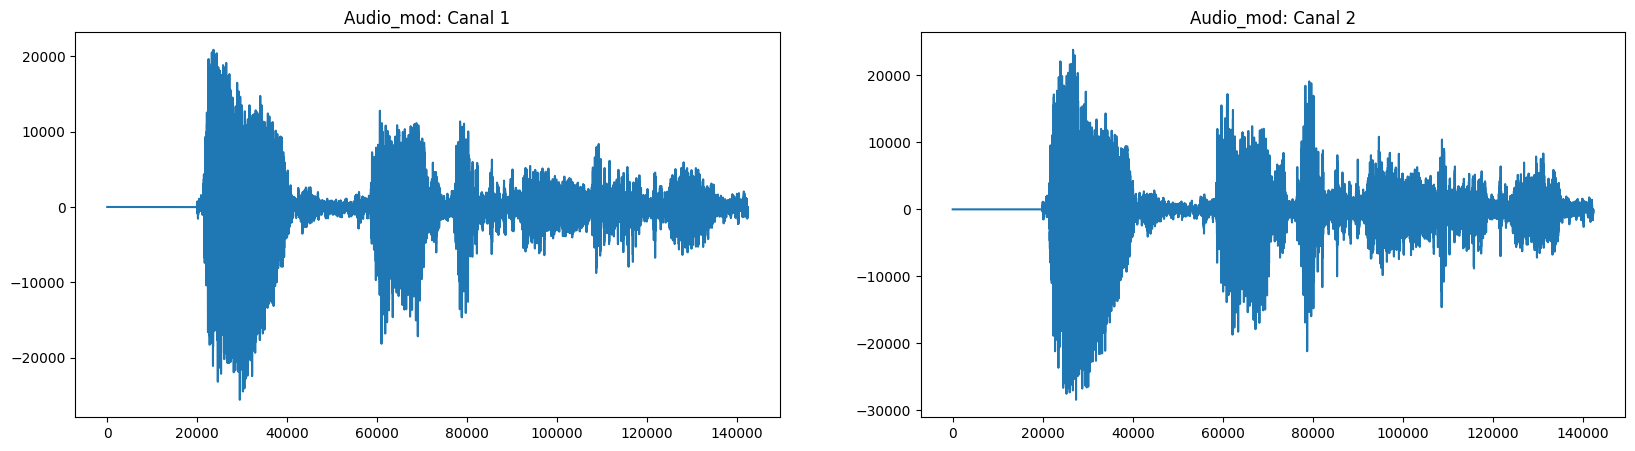

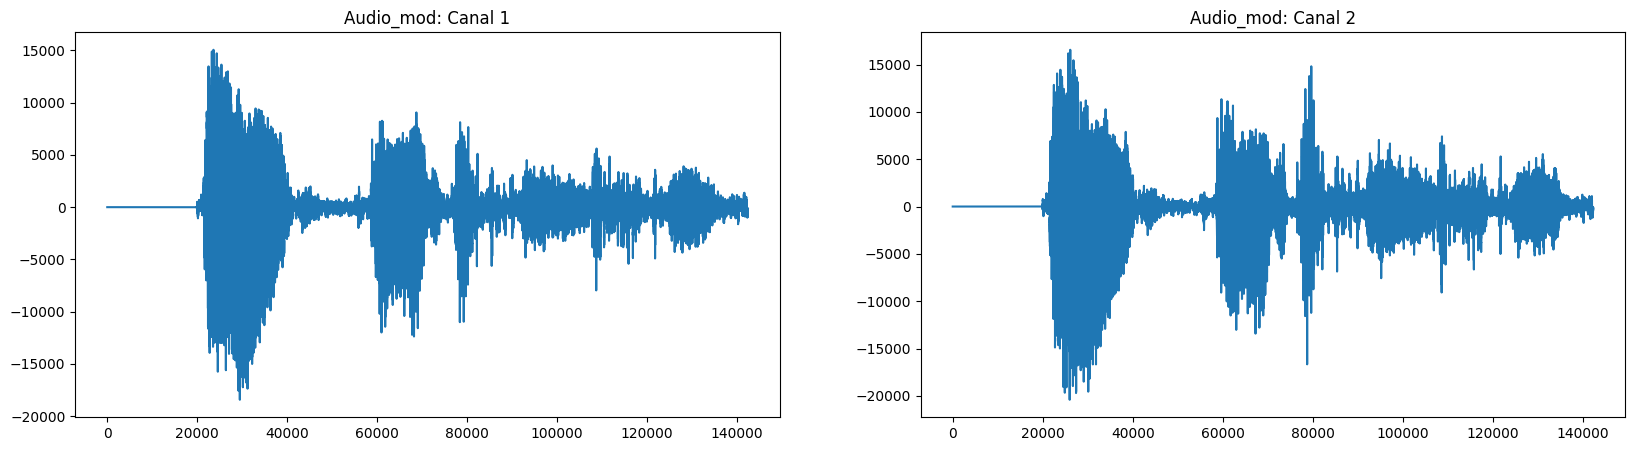

In [4]:
#AUDIO GENERADO SEMI-ALEATORIAMENTE
AUDIO_INICIAL = np.zeros([AUDIO.shape[0],2])
AUDIO_INICIAL[:,0] = [x*amp for x in pob1_i[0]]
AUDIO_INICIAL[:,1] = [x*amp for x in pob2_i[0]]
#AUDIO PROCESADO
AUDIO_PROC = np.zeros([AUDIO.shape[0],2])
AUDIO_PROC[:,0] = [x*amp for x in pob1[0]]
AUDIO_PROC[:,1] = [x*amp for x in pob2[0]]

IMPRIMIR_AUDIO(AUDIO*amp,name='Audio_org',save=True)
IMPRIMIR_AUDIO(AUDIO_INICIAL,name='Audio_mod',save=True)
IMPRIMIR_AUDIO(AUDIO_PROC,name='Audio_mod',save=True)
os.remove(Audio_mod)
wavfile.write(Audio_mod,rate,AUDIO_PROC.astype(np.int16))

In [5]:
playsound(Audio)
playsound(Audio_mod)